# Main Notebook for MultiChannelStrategy Project

This Jupyter Notebook will follow all steps of our analysis. For the purpose of running this notebook and demonstrating tangible results, we provided a dataset in the CSV file format. This will be the basis for the following analysis.

## 0. Import Packages and Libraries

In [19]:
import pandas as pd

import statsmodels.formula.api as smf

from omnichannelstrategy.preprocessing.syntheticcontrol import scm_preprocessing
from omnichannelstrategy.main.scmplotting import CustomSynth, beautify_scm_plot

from omnichannelstrategy.main.alternativecontrol import alternative_control_preprocessing, AlternativeControl

from omnichannelstrategy.main.did import (did_preprocessing, get_before_after_opening_quarters, get_nearest_neighbors, 
                                          generate_regression_city_df, prepare_did_export_for_R)

## 1. Synthetic Control Method

In this section we apply the *Synthetic Control Method* (hereafter SCM). 

Explanation of Synthetic Control: In general terms, the goal of SCM is the creation of a so-called synthetic copy of the treated unit which never received treatment. This is done by computing a weighted average of the control units that closely resembles the pre-treatment characteristics of the treated unit. The assumption of SCM is then, that the computed relation between control units and treated unit would have continued in the absence of treatment.

For the execution of SCM in python we use the 
SyntheticControlMethods package from OscarEngelbrektson, where you can find further explanation of SCM. You can access the original package [here](https://github.com/OscarEngelbrektson/SyntheticControlMethods]).

First, we have to load the dataset (which we provided). You can specify another path, if you moved the file somewhere else.

In [2]:
df_treated = pd.read_csv("../data/omni_preprocessed_data.csv", dtype={'shipping_post_code':str, 
                                                                      'treatment_store_opening_date':str, 
                                                                      'treatment_store':str})

Next, we will apply some additional preprocessing that will enable us the usage of Synthetic Control Method: 
Basically, for each store we create a new dataframe, that contains all postal codes that received a supposed treatment (i.e. that lie within a certain range to that store), as well as all postal codes that did not receive any supposed treatment (i.e. that do not lie within a certain range to any store). The latter constitutes the so called donor pool of control units.

In addition, all postal codes that have been designated to have received treatment in the vicinity of a store will be aggregated together and assigned the store's general location as their new postal code. We call this the `treatment_area`. For example, all postal codes that lay within 50km of the store in Leipzig will be combined and their variables (order_values, order_quantitites etc.) averaged to form one single entity: Leipzig. This average represents the mean data of all postal codes in the vicinity of the Leipzig, where the store is located.

Furthermore, we restrict our analysis to only encompass a certain time frame before and after the opening of the store. In our example, we chose 12 quarters before and after (i.e. 3 years). That means, for a store that opened in 2018Q2 , we only look at the data between the 2015Q2 and 2021Q2. Lastly, we have to convert the quarter column for our analysis. Originally, we encoded the absolute quarters (eg. 2018Q2) as the number of quarters since the opening of a store (i.e. application of treatment). This, of course, assigns quarters that lie before the opening date of the store, a negative number. Because the SyntheticControlMethods package, which we use, requires only positive numbers, we finally have to convert the number of quarters to be strictly positive. We do this by adding the number of quarters before the treatment (in our example 12) to have the values start at 0. Conceptually, we named this column then `q_since_observation`, because it now represents the number of quarters since the beginning of time frame we specifically look at in our anlysis.

City 1 - SCM Preprocessing

In [3]:
df_city1 = scm_preprocessing(df_input=df_treated, treatment_area='city1', num_quarter_before=12, num_quarter_after=12, dropna=False, earliest_quarter='2013Q2')

Number of postal codes aggregated: 9250 / 25 = 370.0


Our dataframe now looks like this:

In [4]:
df_city1.head()

,shipping_post_code,q_since_observation,order_value,number_of_returned_items,number_of_orders,number_of_items,return_rate,credit_score,order_value_2013Q2,population_density_per_sqkm,Group
0,0,0,466.923077,11.0,32.0,66.0,0.166667,0.702739,466.923077,4763.056129,Non_Store
1,0,1,337.076923,6.0,29.0,50.0,0.120000,0.702739,466.923077,4763.056129,Non_Store
2,0,2,585.461538,10.0,44.0,78.0,0.128205,0.702739,466.923077,4763.056129,Non_Store
3,0,3,625.307692,13.0,43.0,64.0,0.203125,0.702739,466.923077,4763.056129,Non_Store
4,0,4,491.153846,4.0,31.0,43.0,0.093023,0.702739,466.923077,4763.056129,Non_Store


For each quarter between 2013Q2 and 2019Q2, the dataframe holds our treatment area and our donor pool of control units, consisting of 7264 postal codes that did not receive treatment (i.e. do not lie within 50 km of any store). As mentioned before, the quarters are encoded as 'the number of quarters from the start of our analysis time frame'. In addition we have several variables that can be used to refine the SCM (return_rate, credit_score, population_density_per_sqkm etc.).

Now follows the actual application of SCM. From the control donor pool, the method tries to find the closest linear relation to our treatment_area before the apllication of the treatment. In other terms, it will create a *synthetic* treatment_area that should closely resemble the real treatment_area up until the beginning of the treatment. 

In our example, in the time frame before the opening of the Leipzig store in 2018Q2, the Synthetic Control module will create a synthetic Leipzig. Mathematically speaking, the module assigns weights to each postal code in the donor pool and minimises the error between the actual variable values and those of the synthetic treatment area.

Using these weights the method will then compute the development of synthetic Leipzig after the opening of the store without having seen the real data for Leipzig in this time frame. This then theoretically resembles the development of Leipzig had it not received treatment. 

The difference between real Leipzig and synthetic Leipzig then shows the treatment effect, i.e. the impact of opening stores on online sales in the treatment area.

**City 1 - Synthetic Control Execution & Plot**

For the generation of our synthetic control, we use the above mentioned SyntheticControlMethods package:

The variable of interest for our analysis (`outcome_var`) is the `order_value`.
The variable, which identifies the treatment units and the control units (`id_var`) is `shipping_post_code`.
The time variable (`time_var`) are our encoded quarters in the `q_since_observation` column. Because of this particular encoding, the beginning of our treatment (`treatment_period`) is set to be `13`, because we have 12 quarters preceding it (per our own definition of time frame). Then we also specify what label our treatment unit (`treated_unit`) has in the dataframe: 'Leipzig'.
Additionally, we can specify two parametres for the actual calculation:

`pen` - We set this to 100, because we want to prioritise the weights pre-treatment.

`n_opt` - Number of calculations for the optimiser to minimise the loss function.

In [5]:
df_city1_scm = df_city1[['shipping_post_code', 'q_since_observation', 'order_value', "credit_score", 
                   #"population_density_per_sqkm",
                   #"order_value_2015Q1"
                   ]]

csc_city1 = CustomSynth(dataset=df_city1_scm,
                     outcome_var="order_value",
                     id_var="shipping_post_code",
                     time_var='q_since_observation', 
                     treatment_period=13,
                     treated_unit="city1",
                     pen=100,
                     n_opt=10
                     );

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.85060D+04    |proj g|=  5.00000D-01

At iterate    3    f=  3.19210D+03    |proj g|=  4.23806D-01

At iterate    6    f=  1.52933D+03    |proj g|=  6.20714D-01

At iterate    9    f=  1.52933D+03    |proj g|=  6.20710D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     13     10     0     0   6.207D-01   1.529D+03
  F =   1529.3346493347358     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  3.53054D+03    |proj g|=  6.04440D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     56     10     0     0   6.044D-01   3.531D+03
  F =   3530.5371807650818     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03020D+04    |proj g|=  6.82599D-01

At iterate    3    f=  1.53040D+03    |proj g|=  4.01662D-01

At iterate    6    f=  1.52933D+03    |proj g|=  6.21599D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     13      9     0     0   4.013D-01   1.529D+03
  F =   1529.3346536732295     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     97     16     2     2   0.000D+00   1.052D+05
  F =   105244.27278943364     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


We can then have a look at some meta-data to interpret the goodness of the fit.

This table shows the difference between the synthetic unit and the actual unit. The values itself are only difficult to interpret and depend on the magnitude of the outcome variable on which they are calculated. The most interesting column is the `pre_rmspe` which shows the error before treatment. The lower it is, the better the fit of the model. What constitutes a low value can be determined by trying different values for the penalty, which will show the possible range this can take.
For our purposes a value of around 200 is quite good and increases our confidence in the model.

In [6]:
# RMSPE
csc_city1.original_data.rmspe_df

,unit,pre_rmspe,post_rmspe,post/pre
0,city1,10.846249,66.620707,6.142281


We can also look at the comparison between our real unit and the synthetic unit at the point right before treatment. The closer all values in column 1 and 2 are together, the better. Here it seems we have an almost perfect fit. The Weighted Mean Average Penalty Error (WMAPE) is also not too important, but the smaller it is compared to the magnitude of their respective values, the better. They also seem to be alright, though the picture is not overwhelmingly clear.

In [7]:
# Data Comparison
csc_city1.original_data.comparison_df

,city1,Synthetic city1,WMAPE,Importance
order_value,363.88,362.94,217.23,0.39
credit_score,0.80,0.77,0.06,0.61


After having minimised the loss for our weights, and thus created a suitable model, we want to plot the results, to get visual confirmation.

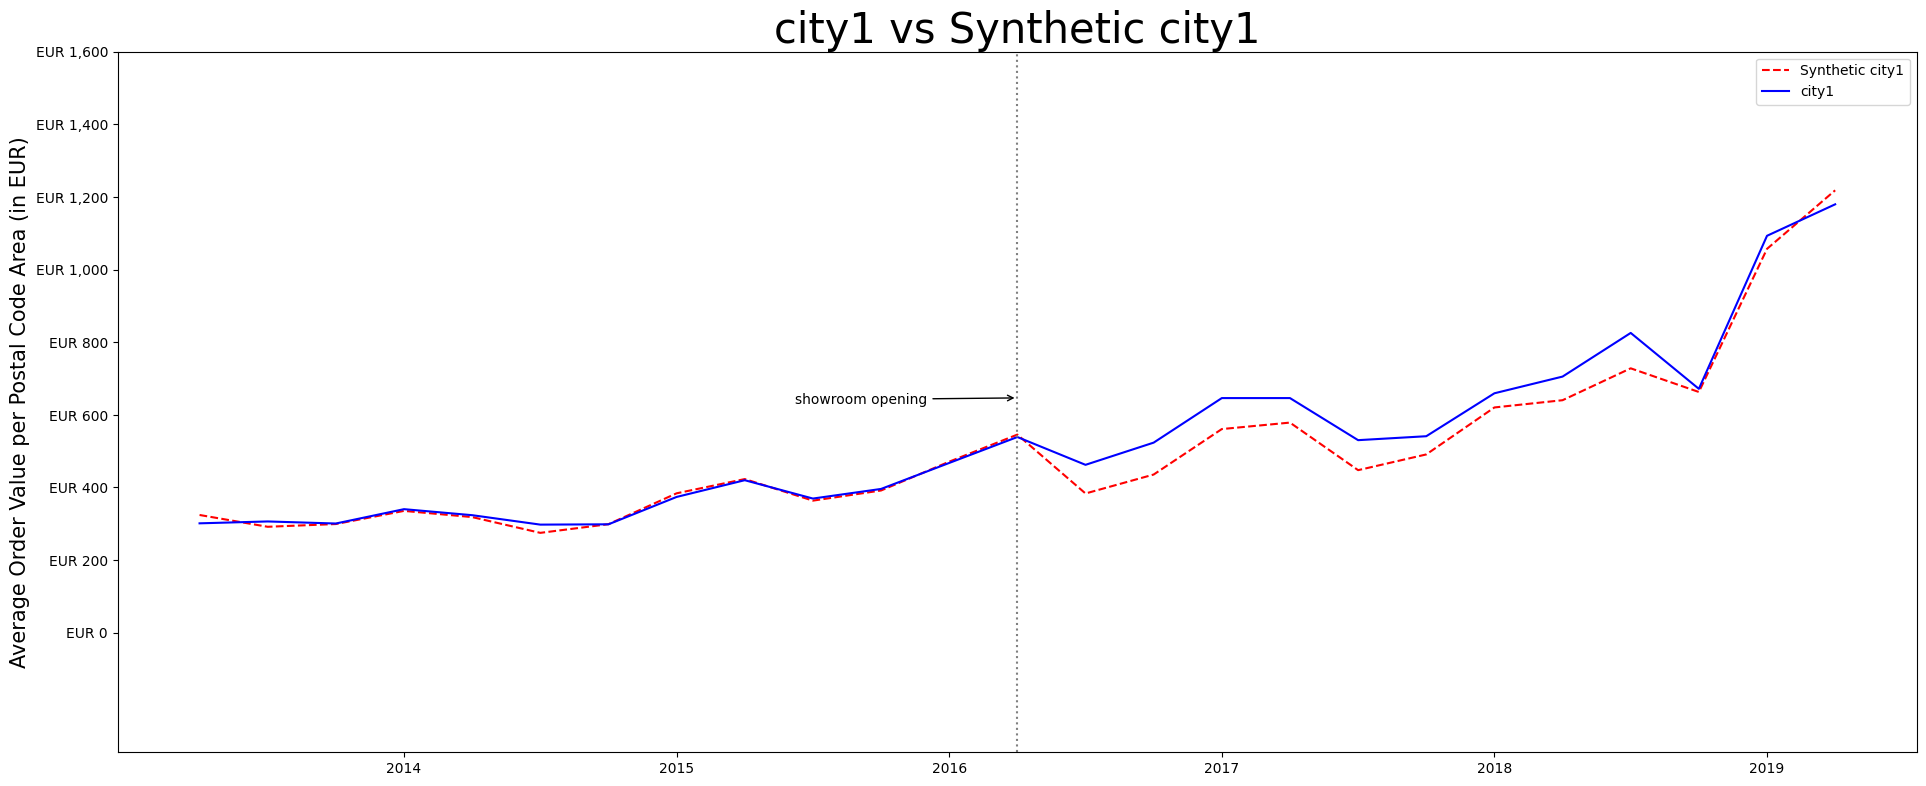

In [8]:
df_stores = pd.read_csv('../data/omni_store_data.csv', dtype={'postal_code':str}).set_index(keys='city')
fig_city1 = csc_city1.custom_plot(["original"], treated_label="city1", synth_label=f"Synthetic city1", treatment_label="showroom opening")
beautify_scm_plot(fig_city1, df_stores, 'city1')

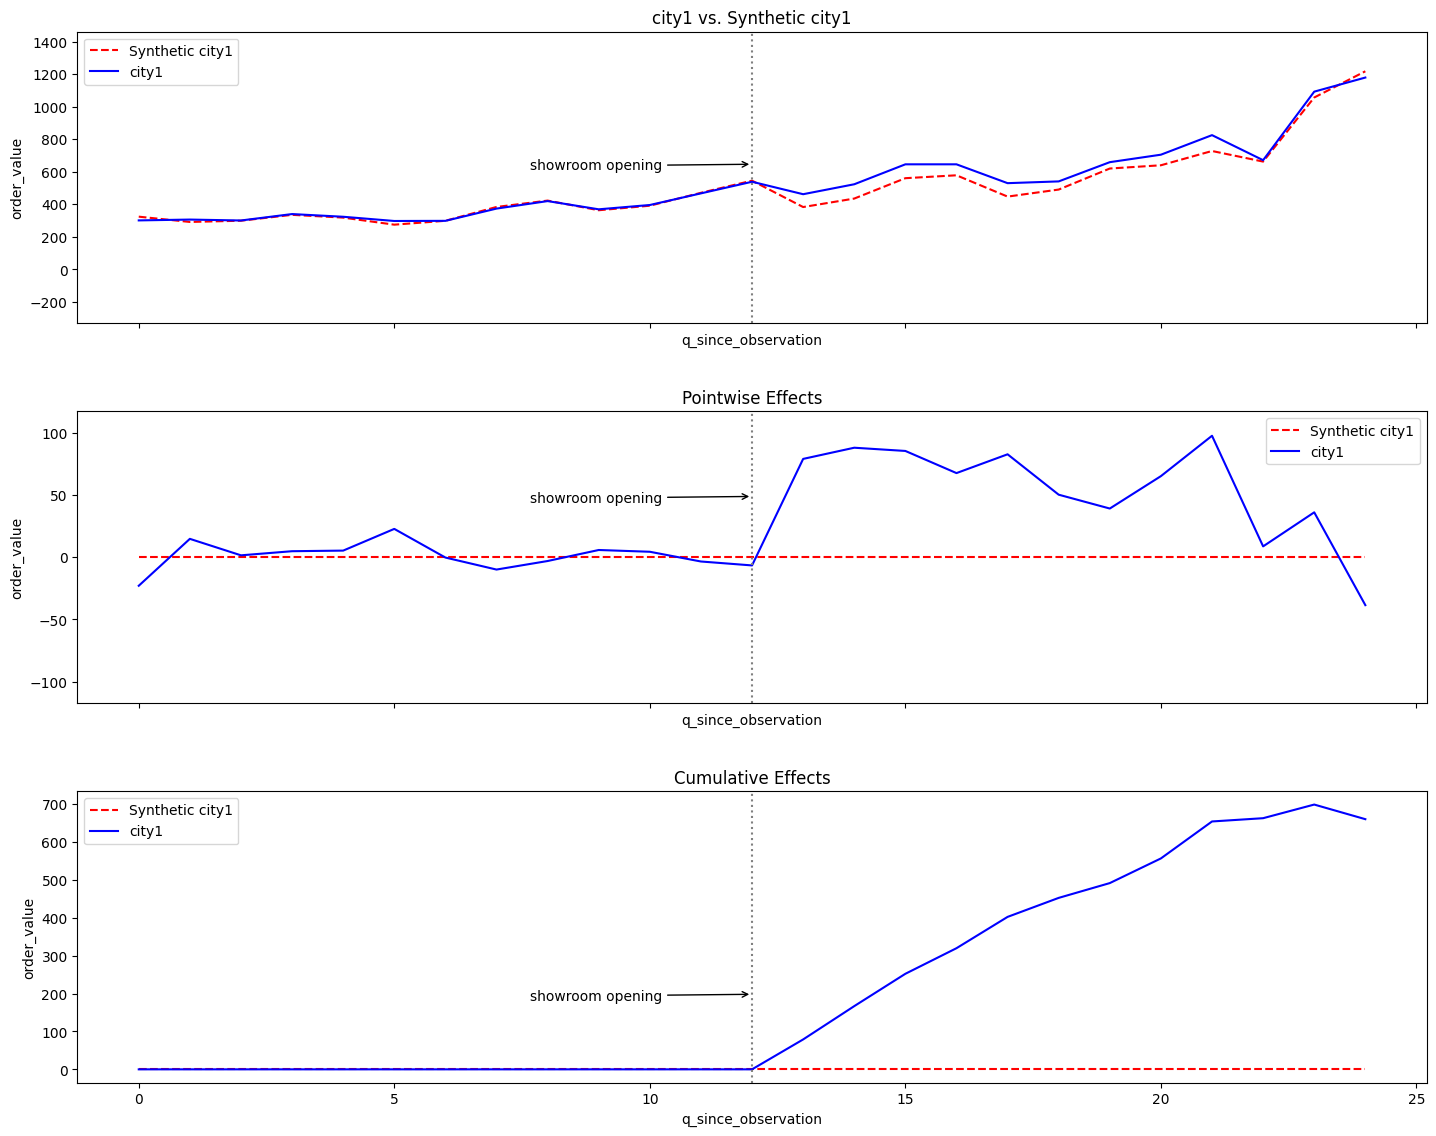

In [9]:
fig_city1 = csc_city1.custom_plot(["original", "pointwise", "cumulative"], treated_label='city1', synth_label=f"Synthetic city1", treatment_label="showroom opening")

We see a clear difference between the synthetic unit and the treated unit. Combined with our metrics, that confirm a somewhat alright fit, we can  conclude a positive effect of the treatment for this particular case, eg. Leipzig.

To have further insight into the effect of treatment effect, we will repeat the process for the second city with a physical store.

**City 2**

In [10]:
df_city2 = scm_preprocessing(df_input=df_treated, treatment_area='city2', num_quarter_before=12, num_quarter_after=12, dropna=False, earliest_quarter='2013Q2')

df_city2_scm = df_city2[['shipping_post_code', 'q_since_observation', 'order_value', "credit_score", "order_value_2013Q2"]]

csc_city2 = CustomSynth(dataset=df_city2_scm,
                     outcome_var="order_value",
                     id_var="shipping_post_code",
                     time_var='q_since_observation', 
                     treatment_period=13,
                     treated_unit="city2",
                     pen=100,
                     n_opt=10
                     );

Number of postal codes aggregated: 4175 / 25 = 167.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29849D+05    |proj g|=  6.66667D-01

At iterate    3    f=  6.15377D+04    |proj g|=  6.73282D-01
  ys=-1.460E+02  -gs= 3.916E+02 BFGS update SKIPPED

At iterate    6    f=  5.80196D+04    |proj g|=  6.71346D-01
  ys=-5.757E-05  -gs= 1.208E-01 BFGS update SKIPPED

At iterate    9    f=  5.80195D+04    |proj g|=  6.71346D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-6.402E-05  -gs= 8.228E-03 BFGS update SKIPPED
  ys=-2.856E-04  -gs= 7.637E-03 BFGS update SKIPPED

At iterate   12    f=  5.80195D+04    |proj g|=  6.71346D-01

At iterate   15    f=  5.80195D+04    |proj g|=  6.71346D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15    146     24     4     0   6.713D-01   5.802D+04
  F =   58019.466620325024     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.53441D+06    |proj g|=  5.93018D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     21      3     0     3   5.930D-01   7.534D+06
  F =   7534413.3292759405     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.64293D+06    |proj g|=  9.98960D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     30      4     0     0   7.468D-01   7.062D+06
  F =   7061629.4350315770     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43420D+05    |proj g|=  8.41348D-01

At iterate    3    f=  5.44297D+04    |proj g|=  8.30373D-01

At iterate    6    f=  5.24898D+04    |proj g|=  8.28661D-01

At iterate    9    f=  5.24010D+04    |proj g|=  8.26321D-01

At iterate   12    f=  5.13637D+04    |proj g|=  7.73825D-01
  ys=-1.402E+03  -gs= 8.105E+02 BFGS update SKIPPED

At iterate   15    f=  5.05559D+04    |proj g|=  7.58294D-01

At iterate   18    f=  4.95776D+04    |proj g|=  7.96749D-01

At iterate   21    f=  4.87534D+04    |proj g|=  7.09391D-01

At iterate   24    f=  4.73410D+04    |proj g|=  7.02162D-01
  ys=-8.771E+00  -gs= 1.486E+02 BFGS update SKIPPED

At iterate   27    f=  4.70698D+04    |proj g|=  6.90754D-01

At iterate   30    f=  4.69400D+04    |proj g|=  6.90075D-01
  ys=-3.431E+00  -gs= 1.007E+01 BFGS update SKI


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.69643D+06    |proj g|=  3.51798D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     21      3     0     3   3.518D-01   7.696D+06
  F =   7696433.9419154860     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53877D+05    |proj g|=  3.34770D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     55      8     0     3   6.652D-01   5.579D+05
  F =   557892.62046269863     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00395D+06    |proj g|=  9.18672D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    3    f=  3.68348D+05    |proj g|=  9.99990D-01
  Positive dir derivative in projection 
  Using the backtracking step 
  ys=-1.783E-09  -gs= 9.186E-03 BFGS update SKIPPED
  Positive dir derivative in projection 
  Using the backtracking step 



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  1.96481D+05    |proj g|=  9.99998D-01

At iterate    9    f=  3.72173D+04    |proj g|=  9.99995D-01
  ys=-2.871E-11  -gs= 3.664E-04 BFGS update SKIPPED

At iterate   12    f=  3.51789D+04    |proj g|=  9.99992D-01
  ys=-1.575E+03  -gs= 6.618E+01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14    164     22     3     0   1.000D+00   3.507D+04
  F =   35074.504678489640     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57442D+06    |proj g|=  9.79849D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     59      8     0     3   8.126D-01   7.546D+06
  F =   7545742.8485830687     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.51276D+06    |proj g|=  6.00764D-01

At iterate    3    f=  1.47006D+06    |proj g|=  9.98864D-01
  ys=-8.785E+09  -gs= 2.428E+07 BFGS update SKIPPED
  ys=-1.625E+07  -gs= 1.612E+07 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5     62     10     2     3   9.989D-01   1.320D+06
  F =   1319595.5708263242     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.05224D+05    |proj g|=  8.40869D-01
  ys=-7.664E+00  -gs= 7.528E+02 BFGS update SKIPPED

At iterate    3    f=  5.04415D+05    |proj g|=  8.40728D-01
  ys=-1.610E-01  -gs= 3.576E-01 BFGS update SKIPPED

At iterate    6    f=  5.04379D+05    |proj g|=  8.40724D-01
  ys=-1.663E-10  -gs= 6.900E-10 BFGS update SKIPPED

At iterate    9    f=  5.04379D+05    |proj g|=  8.40724D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-3.144E+05  -gs= 8.030E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11    112     18     4     3   8.407D-01   5.044D+05
  F =   504378.74146142765     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [11]:
# Penalty
csc_city2.original_data.pen

100

In [12]:
# RMSPE
csc_city2.original_data.rmspe_df

,unit,pre_rmspe,post_rmspe,post/pre
0,city2,51.625082,245.464882,4.75476


In [13]:
# Data Comparison
csc_city2.original_data.comparison_df

,city2,Synthetic city2,WMAPE,Importance
order_value,807.31,791.27,262.96,0.33
credit_score,0.76,0.77,0.05,0.21
order_value_2013Q2,567.35,556.68,181.57,0.46


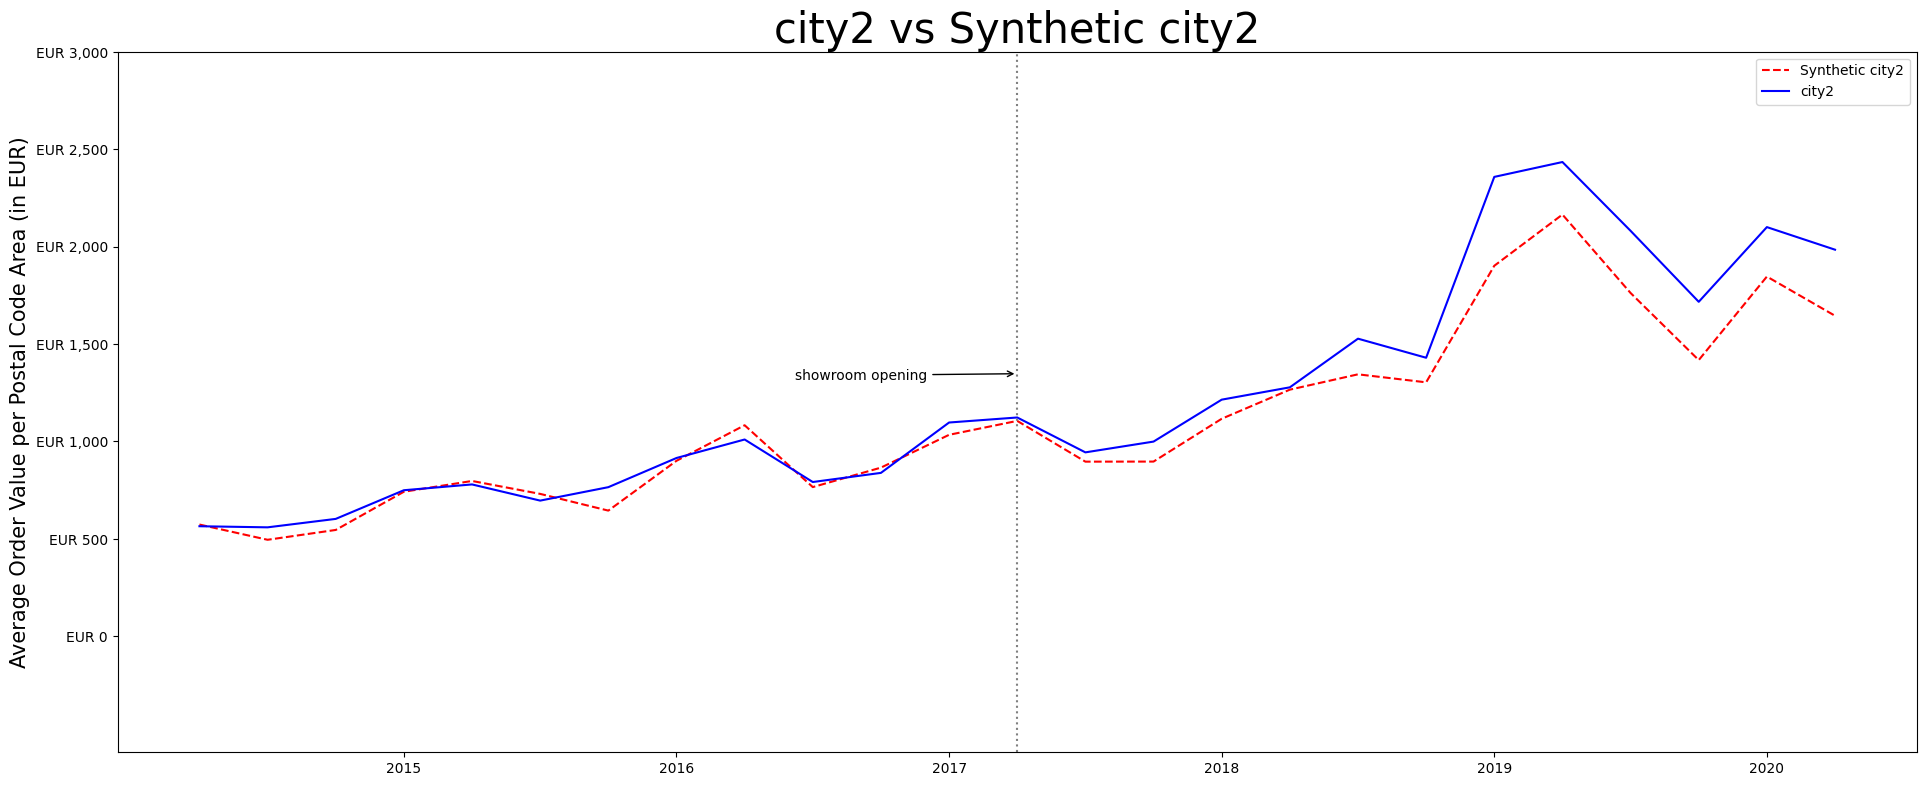

In [16]:
df_stores = pd.read_csv('../data/omni_store_data.csv', dtype={'postal_code':str}).set_index(keys='city')
fig_city2 = csc_city2.custom_plot(["original"], treated_label="city2", synth_label=f"Synthetic city2", treatment_label="showroom opening")
beautify_scm_plot(fig_city2, df_stores, 'city2')

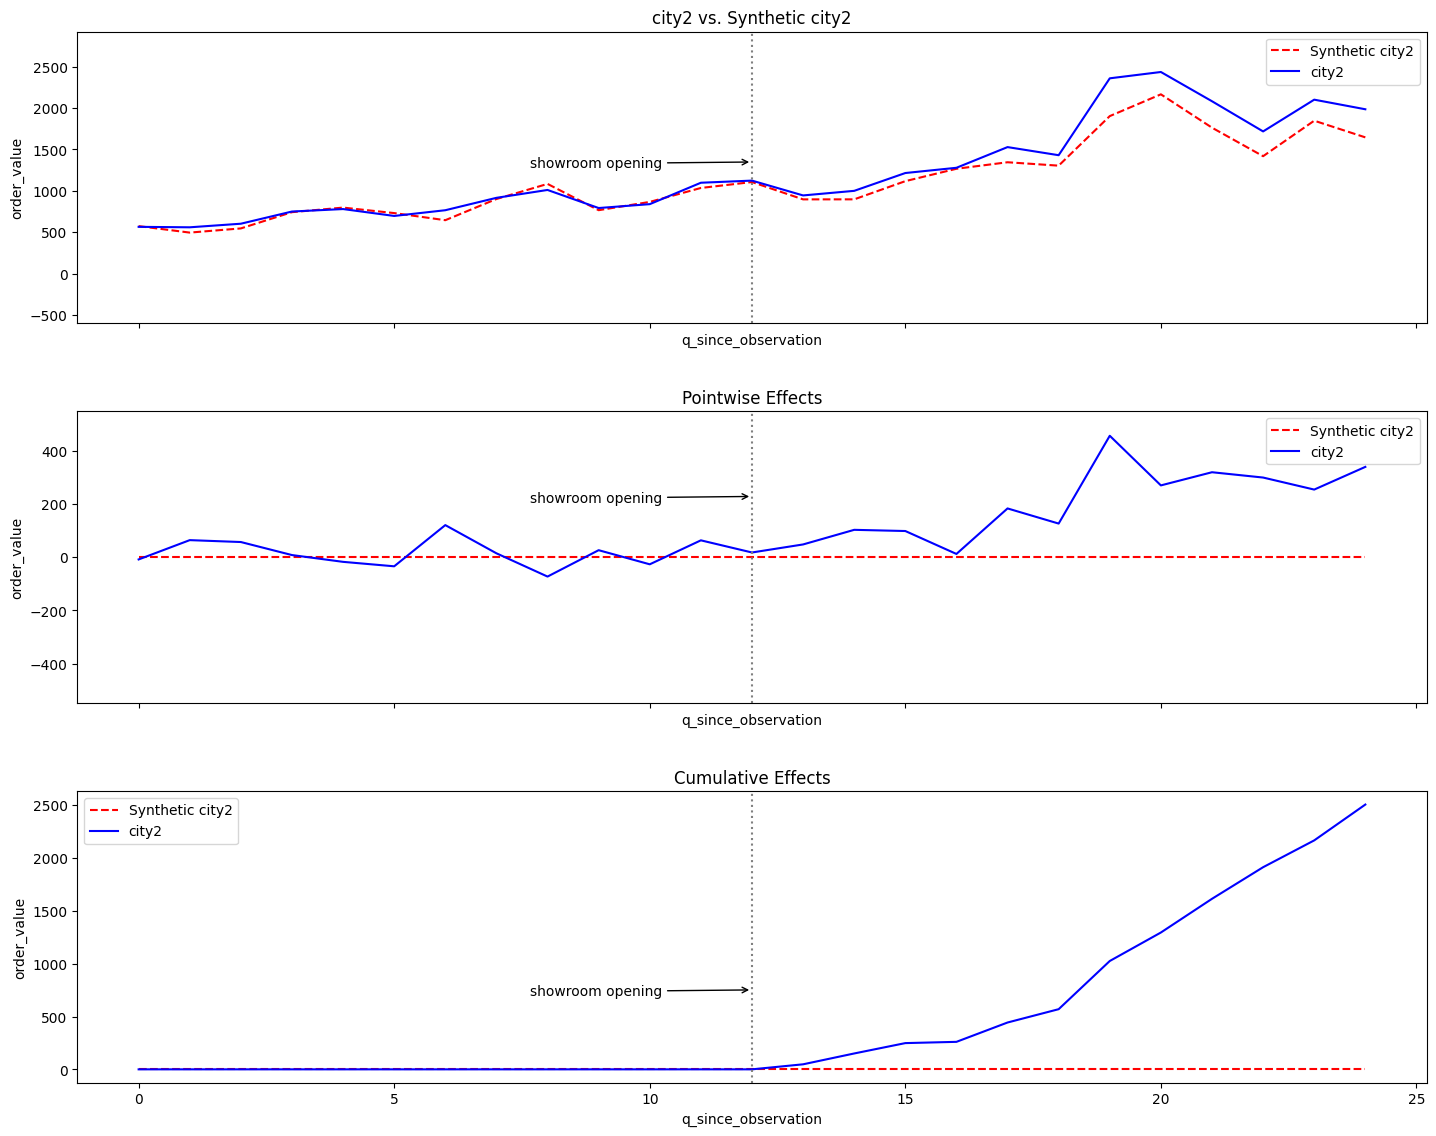

In [17]:
fig_city2 = csc_city2.custom_plot(["original", "pointwise", "cumulative"], treated_label='city2', synth_label=f"Synthetic city2", treatment_label="showroom opening")

## 2. Alternative Control Group

In [18]:
df_treated = pd.read_csv("../data/omni_preprocessed_data.csv", dtype={'shipping_post_code':str, 
                                                                      'treatment_store_opening_date':str, 
                                                                      'treatment_store':str})

In [20]:
df_city1 = alternative_control_preprocessing(df_input=df_treated, treatment_area='city1', num_quarter_before=12, num_quarter_after=12, num_neighbors=1, earliest_quarter='2013Q2', dropna=False)

df_city2 = alternative_control_preprocessing(df_input=df_treated, treatment_area='city2', num_quarter_before=12, num_quarter_after=12, num_neighbors=1, earliest_quarter='2013Q2', dropna=False)

df = pd.concat([df_city1, df_city2], join="inner")

In [21]:
df_stores = pd.read_csv('../data/omni_store_data.csv', dtype={'postal_code':str}).set_index(keys='city')

opening_city1 = df_stores.loc['city1', 'opening_year_quarter']

opening_city2 = df_stores.loc['city2', 'opening_year_quarter']

In [22]:
ac_city1 = AlternativeControl(df, 'city1', opening_city1).fit()

ac_city2 = AlternativeControl(df, 'city2', opening_city2).fit()

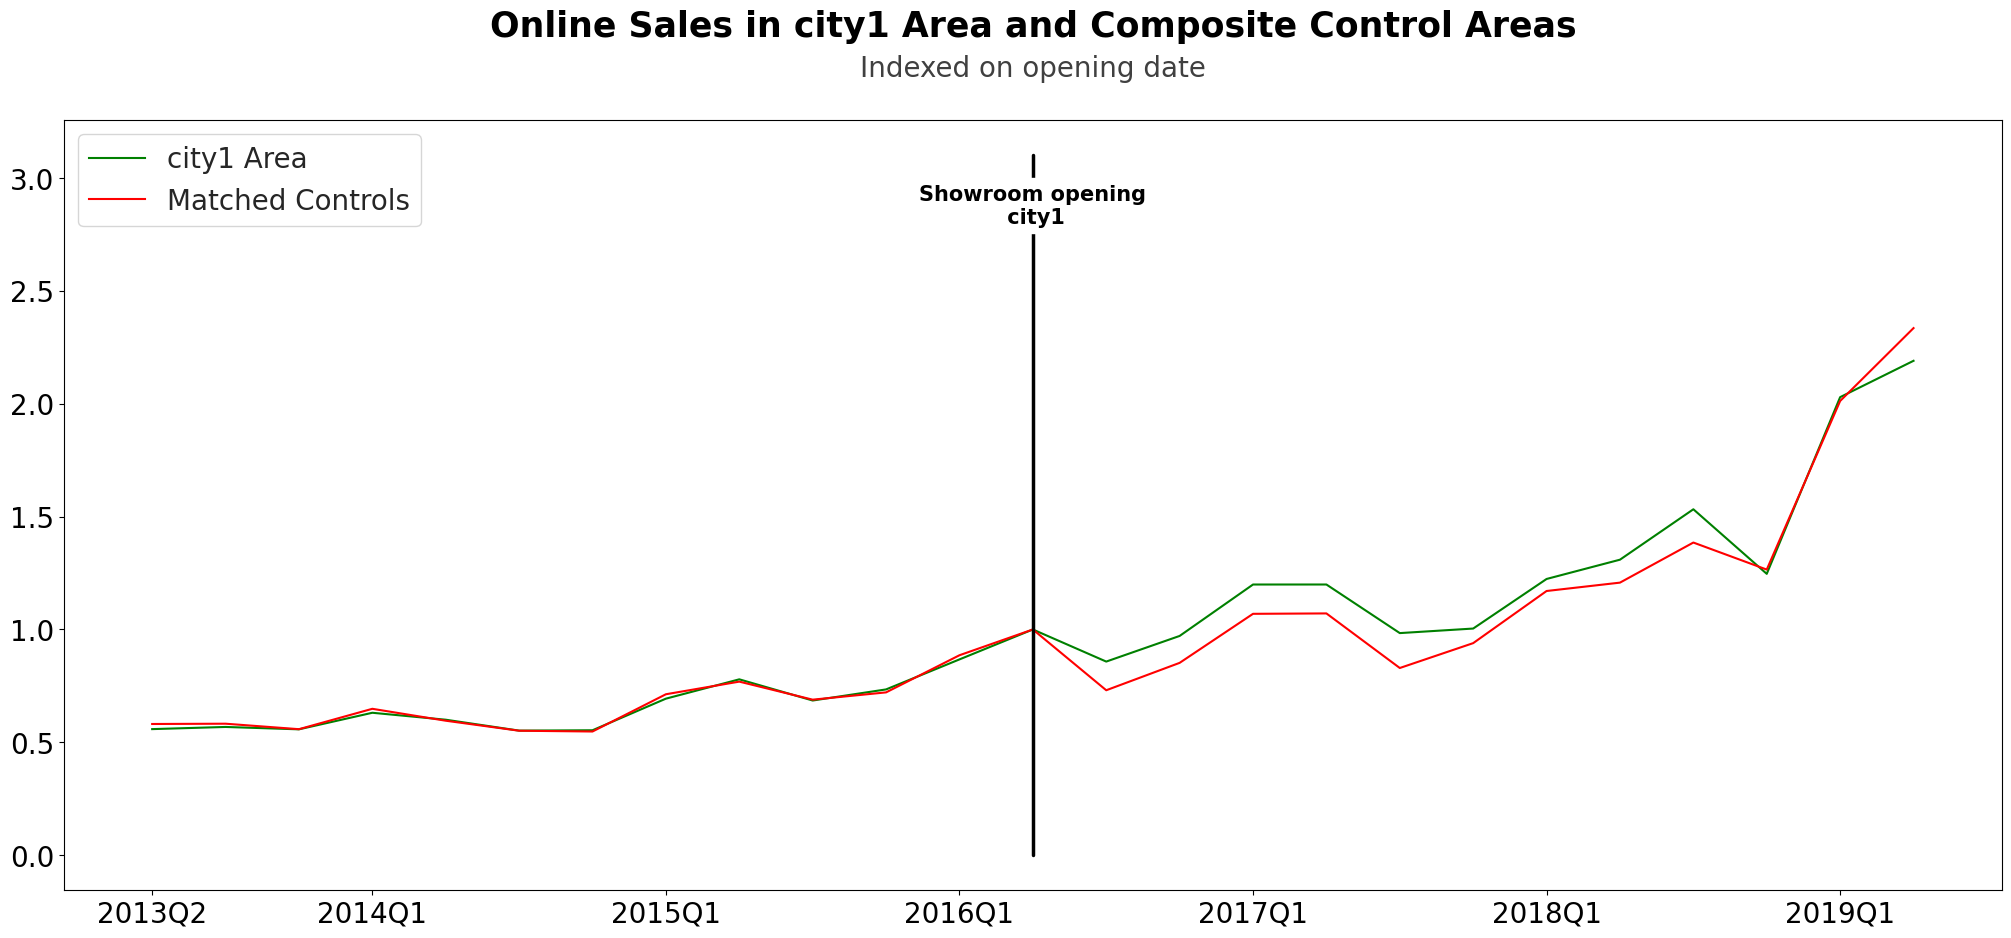

In [23]:
xticks_city1 = ["2013Q2", "2014Q1", "2015Q1", "2016Q1","2017Q1", "2018Q1", "2019Q1"]

# ['matched_control', 'early_stores', 'non_stores]
fig_city1 = ac_city1.plot(graphs=['matched_control'], xticks=xticks_city1, treatment_label='Showroom opening')

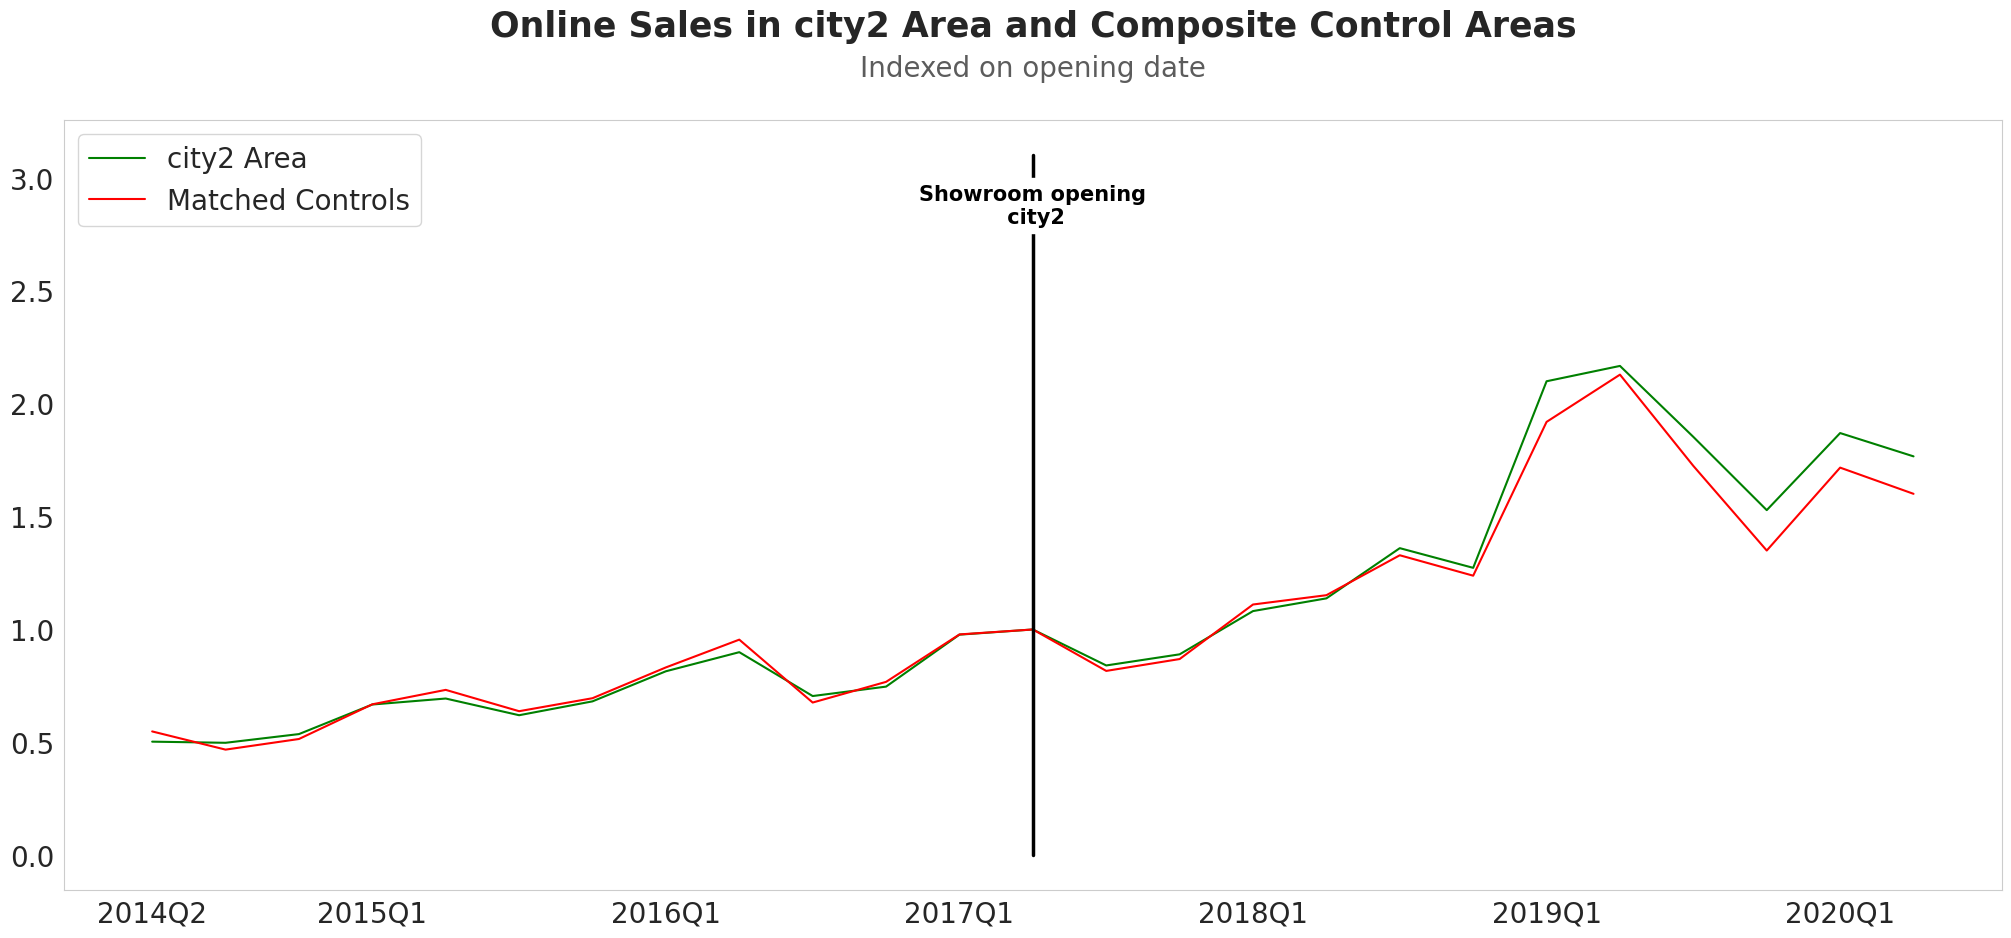

In [24]:
xticks_city2 = ["2014Q2", "2015Q1", "2016Q1","2017Q1", "2018Q1", "2019Q1", "2020Q1"]

fig_city2 = ac_city2.plot(graphs=['matched_control'], xticks=xticks_city2, treatment_label='Showroom opening')

## 3. DiD

(WIP)

Load dataset and transform with further specialised preprocessing.

In [ ]:
df_treated = pd.read_csv("../data/omni_preprocessed_data.csv", dtype={'shipping_post_code':str, 
                                                                      'treatment_store_opening_date':str, 
                                                                      'treatment_store':str})

In [ ]:
df_did = did_preprocessing(df_treated, first_quarter='2013Q2', dropna=False)

Generate overarching dataframe

In [ ]:
num_neighbors = 1

df_city1 = get_before_after_opening_quarters(df_did, treatment_area="city1", num_quarter_before=12, num_quarter_after=12)
df_city1 = get_nearest_neighbors(input_df=df_city1, num_neighbors=num_neighbors)

df_city2 = get_before_after_opening_quarters(df_did, treatment_area="city2", num_quarter_before=12, num_quarter_after=12)
df_city2 = get_nearest_neighbors(input_df=df_city2, num_neighbors=num_neighbors)

df = pd.concat([df_city1, df_city2], join="inner")

**DiD for city1**

In [ ]:
df_city1 = generate_regression_city_df(input_df=df, treatment_area='city1')

In [ ]:
smf.ols('log_order_value ~ Treatment_x_Post + Treatment + Post + order_value_firstQ + population_density_per_sqkm + credit_score', data=df_city1).fit(use_t=True, cov_type='cluster', cov_kwds={'groups': df_city1['shipping_post_code']}).summary() #.tables[1]

In [ ]:
smf.ols('log_order_value ~ dist_0_10km_x_Post + dist_10_20km_x_Post + dist_20_30km_x_Post + dist_30_40km_x_Post + dist_40_50km_x_Post + Post + order_value_firstQ + population_density_per_sqkm + credit_score + dist_0_10km + dist_10_20km + dist_20_30km + dist_30_40km + dist_40_50km', data=df_city1).fit(use_t=True, cov_type='cluster', cov_kwds={'groups': df_city1['shipping_post_code']}).summary() #.tables[1]

**DiD for city 2**

In [ ]:
df_city2 = generate_regression_city_df(input_df=df, treatment_area='city2')

In [ ]:
smf.ols('log_order_value ~ Treatment_x_Post + Treatment + Post + order_value_firstQ + population_density_per_sqkm + credit_score', data=df_city2).fit(use_t=True, cov_type='cluster', cov_kwds={'groups': df_city2['shipping_post_code']}).summary() #.tables[1]

In [ ]:
smf.ols('log_order_value ~ dist_0_10km_x_Post + dist_10_20km_x_Post + dist_20_30km_x_Post + dist_30_40km_x_Post + dist_40_50km_x_Post + Post + order_value_firstQ + population_density_per_sqkm + credit_score + dist_0_10km + dist_10_20km + dist_20_30km + dist_30_40km + dist_40_50km', data=df_city2).fit(use_t=True, cov_type='cluster', cov_kwds={'groups': df_city2['shipping_post_code']}).summary() #.tables[1]

**Prepare Dataset for Analysis with R**

In [ ]:
df_exp = prepare_did_export_for_R(df_input=df_did, treatment_area_list=['city1', 'city2', 'city3', 'city13'], cohort_date_anchor='city4')

In [ ]:
# Export dataframe with 'feather' ib raw_data directory
# df_exp.to_feather('../raw_data/df_exp_to_R.feather')